__Задание 1__

В этом задании вы должны модифицировать реализацию рассчёта среднеквадратичной ошибки и рассчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регулярязационная поправка: $ +c*\sum \limits _{j}  w_{j}^2 $ а к градиенту- ссответствующее выражение для градиента регулярязационной поправки.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as sklearn_LR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
class linear_regression:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
        return self
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

In [3]:
class linear_regression_L2(linear_regression):
    def __init__(self, reg=1, *args, **kwargs):
        self.reg = reg
        super().__init__(*args, **kwargs)
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        penalty = self.reg*(np.sum([el**2 for el in self.w])+self.w0**2)
        return np.sum((y - y_real)**2)/y_real.shape[0] + penalty
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0]+2*self.reg*self.w, np.sum(2*delta)/y_real.shape[0]+2*self.reg*self.w0

__Задание 2__

На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока.

In [4]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)

class polynomial_regression_L2(polynomial_regression):
    def __init__(self, reg=1, *args, **kwargs):
        self.reg=reg
        super().__init__(*args, **kwargs)
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        penalty = self.reg*(np.sum([el**2 for el in self.w])+self.w0**2)
        return np.sum((y - y_real)**2)/y_real.shape[0] + penalty
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0]+2*self.reg*self.w, np.sum(2*delta)/y_real.shape[0]+2*self.reg*self.w0

In [5]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3

In [6]:
def graph(x, y:list, name=None):
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.ylim(-5000, 5000)
    plt.xlim(-10,10)
    for ind,el in enumerate(y):
        if name != None:
            plt.plot(x, y[ind], label=name[ind])
        else:
            plt.plot(x, y[ind])
    if name != None:
        plt.legend()
    plt.show()

In [7]:
# Возьмем 3 признака и 100 объектов
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 100)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 100)

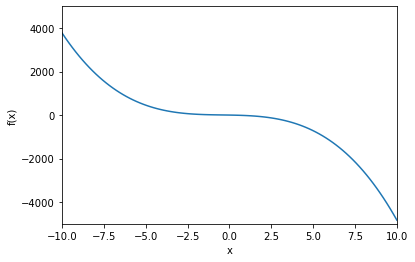

In [8]:
dots = np.linspace(-10, 10, 100)
graph(dots, [f(dots)])

In [9]:
ridge = Ridge(alpha=0.5)
ridge.fit(polynomial_regression.generate_features(x_data, 3), f_data)
y_train_pred = ridge.predict(polynomial_regression.generate_features(x_data, 3))

print(f'coef_ = {ridge.coef_}')
print(f'intercept_ = {ridge.intercept_}')
print(f'MSE sklearn_Ridge: {round(mean_squared_error(f_data, y_train_pred),4)}')

coef_ = [25.46365843 -3.98596882 -4.70248711]
intercept_ = -52.895878650072405
MSE sklearn_Ridge: 330992.0614


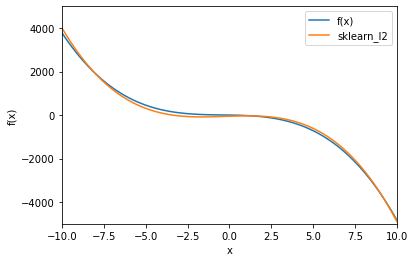

In [10]:
f_ridge = [ridge.intercept_ + np.sum([coef*x_dots**(ind+1) for ind,coef in enumerate(ridge.coef_)]) for x_dots in dots]
graph(dots, [f(dots), f_ridge], name=['f(x)', 'sklearn_l2'])

In [11]:
pr_l2 = polynomial_regression_L2(max_power=3)
pr_l2.fit(x_data,f_data)
print(f'MSE polynomial_regression_L2: {pr_l2.test(x_data,f_data)}')

MSE polynomial_regression_L2: 334916.98566837306


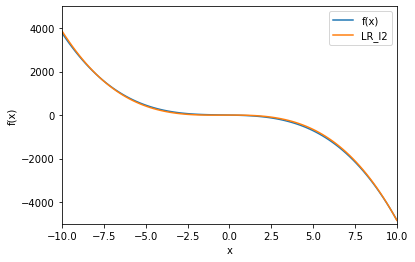

In [12]:
f_pr_l2 = [pr_l2.w0 + np.sum([coef*x_dots**(ind+1) for ind,coef in enumerate(pr_l2.w.flatten())]) for x_dots in dots]
graph(dots, [f(dots), f_pr_l2], name=['f(x)', 'LR_l2'])

In [13]:
ridge = Ridge(alpha=0.5)
ridge.fit(polynomial_regression.generate_features(x_data, 6), f_data)
y_train_pred = ridge.predict(polynomial_regression.generate_features(x_data, 6))

print(f'coef_ = {ridge.coef_}')
print(f'intercept_ = {ridge.intercept_}')
print(f'MSE sklearn_Ridge: {round(mean_squared_error(f_data, y_train_pred),4)}')

coef_ = [ 6.01755034e+01 -7.89057732e+00 -6.54189432e+00 -6.91745971e-02
  1.72015323e-02  1.37716181e-03]
intercept_ = 10.198846680067277
MSE sklearn_Ridge: 322910.7333


In [14]:
sklearn=sklearn_LR()
sklearn.fit(polynomial_regression.generate_features(x_data, 6), f_data)
y_sklearn_pred = sklearn.predict(polynomial_regression.generate_features(x_data, 6))
print(f'MSE sklearn: {round(mean_squared_error(f_data, y_sklearn_pred),4)}')

MSE sklearn: 322910.6773


In [15]:
pr_l2 = polynomial_regression_L2(eta=0.0005, max_power=6, reg=0.5)
pr_l2.fit(x_data,f_data)
print(f'MSE polynomial_regression_L2: {pr_l2.test(x_data,f_data)}')

MSE polynomial_regression_L2: 438308.50353906775


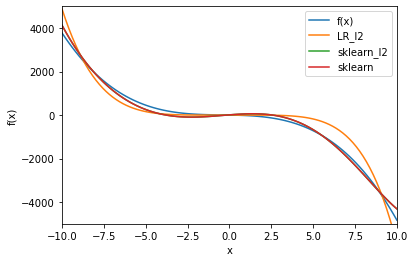

In [16]:
f_ridge = [ridge.intercept_ + np.sum([coef*x_dots**(ind+1) for ind,coef in enumerate(ridge.coef_)]) for x_dots in dots]
f_sklearn = [sklearn.intercept_ + np.sum([coef*x_dots**(ind+1) for ind,coef in enumerate(sklearn.coef_)]) for x_dots in dots]
f_pr_l2 = [pr_l2.w0 + np.sum([coef*x_dots**(ind+1) for ind,coef in enumerate(pr_l2.w.flatten())]) for x_dots in dots]
graph(dots, [f(dots), f_pr_l2, f_ridge, f_sklearn], name=['f(x)', 'LR_l2', 'sklearn_l2', 'sklearn'])

__Задание 3 (по желанию)__

Оцените предсказательную способность реализованного метода с использование 5-ти ступенчатой кросс-валидации.

In [17]:
#Посчитаем р-квадрат регуляризованной полиномиальной регрессии
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total
print(r_square(pr_l2.predict(x_data), f_data))

0.8562225454591696


In [18]:
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_L2(max_power=3)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    print(r_square(y_predicted[i], y_actual[i]))

0.8943455480602314
0.9013641449229537
0.8553181711273915
0.8586385221264499
0.8611888996263


In [19]:
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.8827382518644834


In [20]:
np.sum((y_actual-np.mean(y_actual))**2)/len(y_actual)

3048520.391953322